In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import jax
import jax.numpy as jnp
import flax.linen as nn
from tqdm import tqdm
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import KMeans

import mlflow
from dotenv import load_dotenv
load_dotenv("../.env")

import sys
sys.path.append("..")
from herec.utils import *
from herec.loader import *
from herec.reader import *
from herec.trainer import *
from herec.model import *

In [3]:
def restoreImplicit(datasetName, modelName, seed = 0):
    
    if datasetName == "Twitch100K":
        reader = Twitch100K()
    if datasetName == "ML100K_IMPLICIT":
        reader = ML100K_IMPLICIT()
    if datasetName == "ML1M_IMPLICIT":
        reader = ML1M_IMPLICIT()
    if datasetName == "FourSquare":
        reader = FourSquare()
    
    print( f"{datasetName}-{modelName}-TEST", seed )
    
    # DATA READ
    DATA = reader.get(seed, "test")
    
    # Run IDを取得
    run_id = pl.from_pandas(mlflow.search_runs( experiment_names=[f"{datasetName}-{modelName}-TEST"] )).filter( pl.col("params.seed").cast(int) == seed ).get_column("run_id")[0]
    
    # モデルパラメータ/ハイパーパラメータを取得
    params = restoreModelParams( run_id, -1 )
    hyparams = restoreHyperParams( run_id )
    
    # モデルを取得
    model = getModel( modelName, hyparams, DATA )
    
    # サンプリング
    sampledUserIds = DATA["df_EVALUATION"]["user_ids"][:10]
    sampledItemIds = jax.random.choice(jax.random.PRNGKey(1), jnp.arange(DATA["item_num"]), (100,), replace=False)
    
    # 予測スコア
    pred_scores = model.apply({"params": params}, sampledUserIds, method=model.get_all_scores_by_user_ids)

    # Ground-Truth
    trueItemIds = [vec[vec != -1] for vec in DATA["df_EVALUATION"]["true_item_ids"][:10]]

    print(
        "TRAIN_LOSS",
        pl.from_pandas(mlflow.search_runs( experiment_names=[f"{datasetName}-{modelName}-TEST"] )).filter( pl.col("params.seed").cast(int) == 0 ).get_column("metrics.TRAIN_LOSS/ROUGH")[0],
    )
    print(
        "nDCG@10",
        nDCG := pl.from_pandas(mlflow.search_runs( experiment_names=[f"{datasetName}-{modelName}-TEST"] )).filter( pl.col("params.seed").cast(int) == 0 ).get_column("metrics.nDCG_10")[0],
    )
    
    return sampledUserIds, sampledItemIds, trueItemIds, pred_scores, nDCG

ML100K_IMPLICIT-MF_BPR-TEST 0
[6]


/home/sugahara/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TRAIN_LOSS 0.4197658896446228
nDCG@10 0.039502404630184174
ML100K_IMPLICIT-HE_MF_USER_BPR-TEST 0
[4]


TRAIN_LOSS 0.4174094796180725
nDCG@10 0.04217449948191643
ML100K_IMPLICIT-HE_MF_ITEM_BPR-TEST 0
[37]


TRAIN_LOSS 0.2579090893268585
nDCG@10 0.038178592920303345
ML100K_IMPLICIT-HE_MF_BPR-TEST 0
[2]


TRAIN_LOSS 0.6613796949386597
nDCG@10 0.021427448838949203


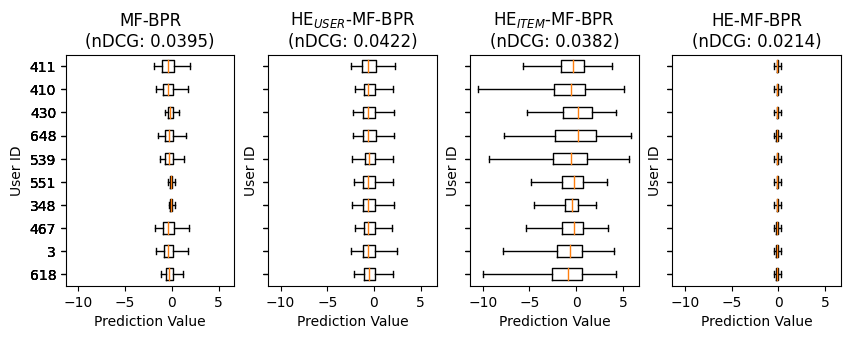

In [4]:
datasetName = "ML100K_IMPLICIT"

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 3))

sampledUserIds, sampledItemIds, trueItemIds, pred_scores, nDCG = restoreImplicit(datasetName, "MF_BPR")
axes[0].boxplot(list(pred_scores), whis=[0, 100], vert=False, labels=list(sampledUserIds))
axes[0].set_title(f"MF-BPR\n(nDCG: {round(nDCG, 4)})")
axes[0].set_xlabel("Prediction Value")
axes[0].set_ylabel("User ID")

sampledUserIds, sampledItemIds, trueItemIds, pred_scores, nDCG = restoreImplicit(datasetName, "HE_MF_USER_BPR")
axes[1].boxplot(list(pred_scores), whis=[0, 100], vert=False, labels=list(sampledUserIds))
axes[1].set_title(f"HE$_{{USER}}$-MF-BPR\n(nDCG: {round(nDCG, 4)})")
axes[1].set_xlabel("Prediction Value")
axes[1].set_ylabel("User ID")

sampledUserIds, sampledItemIds, trueItemIds, pred_scores, nDCG = restoreImplicit(datasetName, "HE_MF_ITEM_BPR")
axes[2].boxplot(list(pred_scores), whis=[0, 100], vert=False, labels=list(sampledUserIds))
axes[2].set_title(f"HE$_{{ITEM}}$-MF-BPR\n(nDCG: {round(nDCG, 4)})")
axes[2].set_xlabel("Prediction Value")
axes[2].set_ylabel("User ID")

sampledUserIds, sampledItemIds, trueItemIds, pred_scores, nDCG = restoreImplicit(datasetName, "HE_MF_BPR")
axes[3].boxplot(list(pred_scores), whis=[0, 100], vert=False, labels=list(sampledUserIds))
axes[3].set_title(f"HE-MF-BPR\n(nDCG: {round(nDCG, 4)})")
axes[3].set_xlabel("Prediction Value")
axes[3].set_ylabel("User ID")

plt.savefig("ratingShrink.pdf", bbox_inches="tight")
plt.show()